In [0]:
import urllib3
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image
import base64

In [0]:
import requests
img = requests.get('https://github.com/rslim087a/road-image/raw/master/test_image.jpg')

In [0]:
arr = np.asarray(bytearray(img.content), dtype=np.uint8)

In [0]:
image = cv2.imdecode(arr, -1)

In [0]:
#@title Default title text
lane_image = np.copy(image)

In [0]:
gray = cv2.cvtColor(lane_image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
canny_image = cv2.Canny(blur, 50, 150)

In [0]:
height = canny_image.shape[0]
polygons = np.array([
                        [(200, height), (1100, height), (550, 250)]
])
mask = np.zeros_like(canny_image)
cv2.fillPoly(mask, polygons, 255)
cropped_image = cv2.bitwise_and(mask, canny_image)

In [0]:
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength = 40, maxLineGap = 5)

In [0]:
line_image = np.zeros_like(lane_image)
for line in lines:
    x1, y1, x2, y2 = line.reshape(4)
    cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)

In [0]:
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)

In [0]:
def make_coordinates(image, line_parameters):
    if(isnan(line_parameters)):
        return np.array([-1, -1, -1, -1])
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1, y1, x2, y2])

def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if(slope < 0):
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis = 0)
    right_fit_average = np.average(right_fit, axis = 0)
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    return np.array([left_line, right_line])


In [0]:
averaged_lines = average_slope_intercept(lane_image, lines)

In [0]:
line_image = np.zeros_like(lane_image)
for x1, y1, x2, y2 in averaged_lines:
    cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)

In [0]:
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)

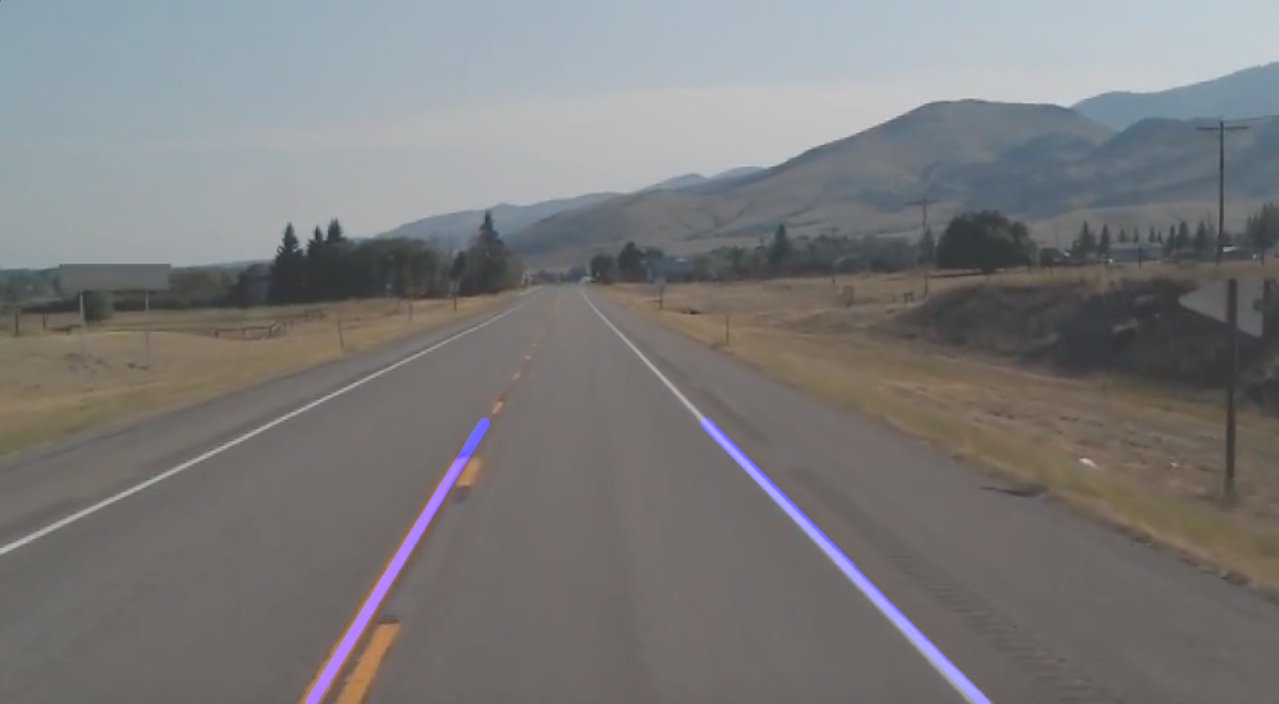

In [0]:
cv2_imshow(combo_image)

In [0]:
vid = requests.get('https://github.com/rslim087a/road-video/raw/master/test2.mp4')

In [0]:
arr = np.asarray(bytearray(vid.content), dtype=np.uint8)

In [0]:
cap =cv2.VideoCapture('https://github.com/rslim087a/road-video/raw/master/test2.mp4')

In [0]:
def isnan(value):
  try:
      import math
      return math.isnan(float(value))
  except:
      return False

In [0]:
def arrayShow (imageArray):
    ret, png = cv2.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Image(data=encoded.decode('ascii'))

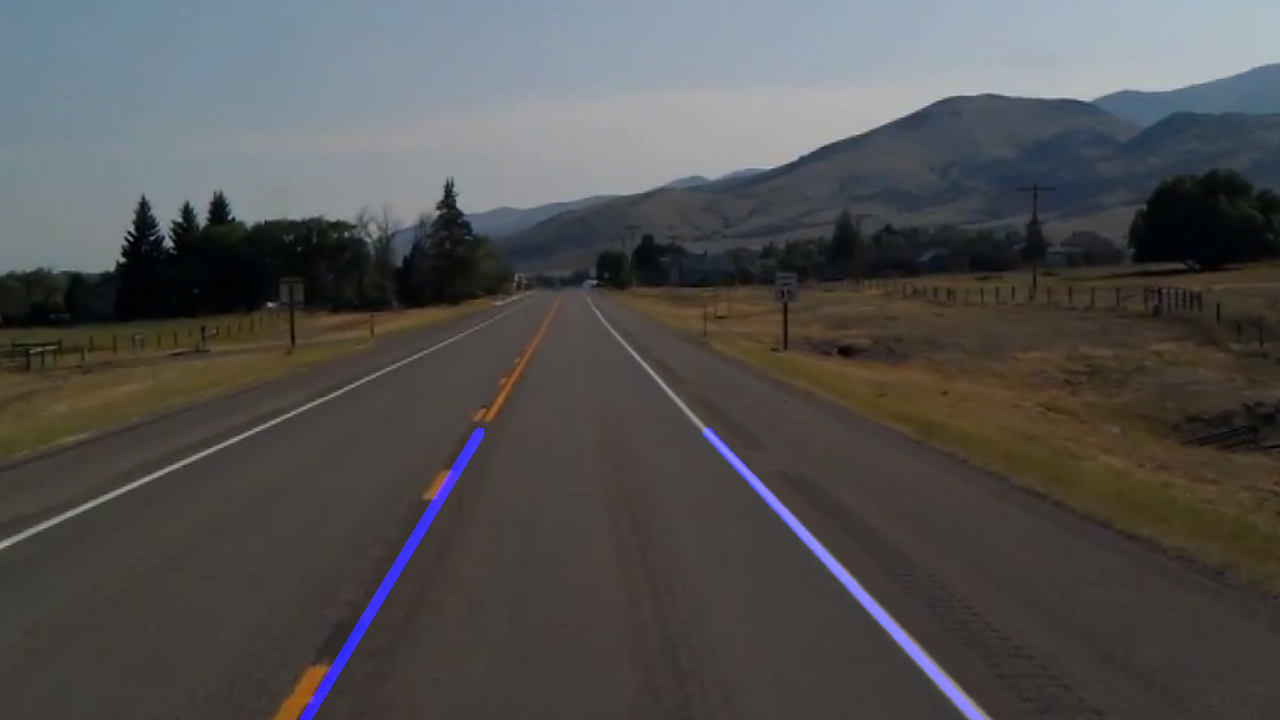

In [0]:
while(cap.isOpened()):
    _, frame = cap.read()
    lane_image = np.copy(frame)
    gray = cv2.cvtColor(lane_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny_image = cv2.Canny(blur, 50, 150)
    height = canny_image.shape[0]
    polygons = np.array([
                            [(200, height), (1100, height), (550, 250)]
    ])
    mask = np.zeros_like(canny_image)
    cv2.fillPoly(mask, polygons, 255)
    cropped_image = cv2.bitwise_and(mask, canny_image)
    lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength = 40, maxLineGap = 5)
    averaged_lines = average_slope_intercept(lane_image, lines)
    line_image = np.zeros_like(lane_image)
    for x1, y1, x2, y2 in averaged_lines:
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
    cv2_imshow(combo_image)